In [1]:
import numpy as np

import skrf
import skrf.media as media
import skrf.frequency as freq
import skrf.network as net
import skrf.util

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

f = freq.Frequency(0.4, 2, 1001)
tem = media.DistributedCircuit(f, z0=50)

bjt = net.Network('BFU520_Spar_NF_400MHz-2GHz/BFU520_05V0_003mA_NF_SP.s2p').interpolate(f)

bjt

2-Port Network: 'BFU520_05V0_003mA_NF_SP',  0.4-2.0 GHz, 1001 pts, z0=[50.+0.j 50.+0.j]

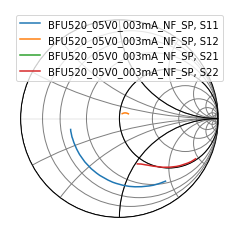

In [2]:
bjt.plot_s_smith()

In [3]:
# calculate the stability circles for the source and load impedances

idx_900mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)

sqabs = lambda x: np.square(np.absolute(x))

delta = bjt.s11.s*bjt.s22.s - bjt.s12.s*bjt.s21.s
rl = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s22.s) - sqabs(delta)))
cl = np.conj(bjt.s22.s - delta*np.conj(bjt.s11.s))/(sqabs(bjt.s22.s) - sqabs(delta))

rl_900mhz = rl[idx_900mhz][0, 0]
cl_900mhz = cl[idx_900mhz][0, 0]

rl_900mhz, cl_900mhz

(2.4087748915771234, (0.8163269481036434+2.8250725890510995j))

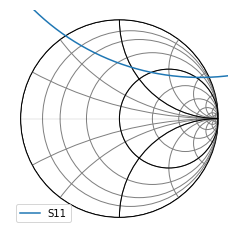

In [4]:
def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

def plot_smith(pts):
    n = net.Network(s=pts)
    n.plot_s_smith()
    
cl_points = calc_circle(cl_900mhz, rl_900mhz)
plot_smith(cl_points)

In [5]:
rs = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s11.s) - sqabs(delta)))
cs = np.conj(bjt.s11.s - delta*np.conj(bjt.s22.s))/(sqabs(bjt.s11.s) - sqabs(delta))

rs_900mhz = rs[idx_900mhz][0, 0]
cs_900mhz = cs[idx_900mhz][0, 0]

rs_900mhz, cs_900mhz

(3.2273035636098206, (-2.6077959539714635+2.662169442645758j))

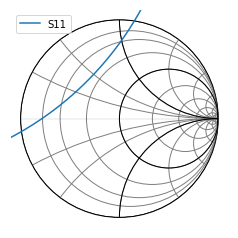

In [6]:
cs_points = calc_circle(cs_900mhz, rs_900mhz)
plot_smith(cs_points)

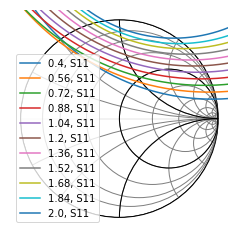

In [7]:
# let's plot all of them
# output stability first

for i, f in enumerate(bjt.f):
    # decimate it a little
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cl[i][0, 0], rl[i][0, 0]))
    n.plot_s_smith()

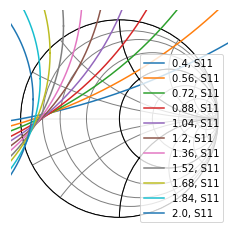

In [8]:
# input stability
for i, f in enumerate(bjt.f):
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cs[i][0, 0], rs[i][0, 0]))
    n.plot_s_smith()

In [9]:
# so not very useful, because the transistor isn't unconditionally stable
# time to draw the circles of constant gain and try to find a useful point

K = (1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) - sqabs(delta))/(2*np.absolute((bjt.s12.s)*(bjt.s21.s)))
G_msg = np.absolute(bjt.s21.s)/np.absolute(bjt.s12.s)
10*np.log10(G_msg[idx_900mhz, 0, 0])

18.162936250002936

the optimum source reflection coefficient is  (0.22496922154681992+0.25679818766727663j)


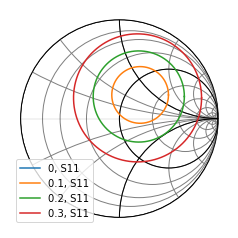

In [10]:
# let's draw some constant noise circles
# first we grab the noise parameters for our target frequency from the network model
idx_915mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)

# we need the normalized equivalent noise and optimum source coefficient to calculate the constant noise circles
rn = bjt.rn[idx_915mhz]/50
gamma_opt = bjt.g_opt[idx_915mhz]
fmin = bjt.nfmin[idx_915mhz]

for nf_added in [0, 0.1, 0.2, 0.3]:
    nf = 10**(nf_added/10) * fmin
    
    N = (nf - fmin)*abs(1+gamma_opt)**2/(4*rn)
    c_n = gamma_opt/(1+N)
    r_n = 1/(1-N)*np.sqrt(N**2 + N*(1-abs(gamma_opt)**2))
    
    n = net.Network(name=str(nf_added), s=calc_circle(c_n, r_n))
    n.plot_s_smith()

print("the optimum source reflection coefficient is ", gamma_opt)

In [11]:
# let's see if we can get a good NF with a point closer to a conjugate match to maximize gain
gamma_s = np.conj(bjt.s11.s[idx_900mhz, 0, 0])
gamma_s

(-0.15947683947506197+0.5979940278898868j)

In [12]:
# that looks pretty close to unstable so let's just match to 50 ohms, which gives <0.1 dB additional NF
gamma_s = 0.0

In [22]:
# so I need to calculate the load reflection coefficient to get a conjugate match when the input sees 50 ohms
gamma_l = np.conj(bjt.s22.s - bjt.s21.s*gamma_s*bjt.s12.s/(1-bjt.s11.s*gamma_s))
is_gamma_l_stable = np.absolute(gamma_l[idx_900mhz, 0, 0] - cl_900mhz) > rl_900mhz

gamma_l = gamma_l[idx_900mhz, 0, 0]
gamma_l, is_gamma_l_stable

((0.5801464368587828+0.25984561092937586j), True)

In [23]:
def calc_matching_network_vals(z1, z2):
    flipped = np.real(z1) < np.real(z2)
    if flipped:
        z2, z1 = z1, z2
        
    # cancel out the imaginary parts of both input and output impedances    
    z1_par = 1e+10
    if abs(np.imag(z1)) > 1e-6:
        # parallel something to cancel out the imaginary part of
        # z1's impedance
        z1_par = 1/(-1j*np.imag(1/z1))
        z1 = 1/(1./z1 + 1/z1_par)
    z2_ser = 0.0
    if abs(np.imag(z2)) > 1e-6:
        z2_ser = -1j*np.imag(z2)
        z2 = z2 + z2_ser
        
    Q = np.sqrt((np.real(z1) - np.real(z2))/np.real(z2))
    x1 = -1.j * np.real(z1)/Q
    x2 = 1.j * np.real(z2)*Q
    
    x1_tot = 1/(1/z1_par + 1/x1)
    x2_tot = z2_ser + x2
    if flipped:
        return x2_tot, x1_tot
    else:
        return x1_tot, x2_tot

z_l = net.s2z(np.array([[[gamma_l]]]))[0,0,0]
# note that we're matching against the conjugate;
# this is because we want to see z_l from the BJT side
# if we plugged in z the matching network would make
# the 50 ohms look like np.conj(z) to match against it, so
# we use np.conj(z_l) so that it'll look like z_l from the BJT's side
z_par, z_ser = calc_matching_network_vals(np.conj(z_l), 50)
z_l, z_par, z_ser

((122.21458153380792+106.58288288611662j),
 -227.59098445995284j,
 90.8749465076289j)

In [24]:
# let's calculate what the component values are
c_par = np.real(1/(2j*np.pi*915e+6*z_par))
l_ser = np.real(z_ser/(2j*np.pi*915e+6))

c_par, l_ser

(7.642650209913709e-13, 1.5806772611913347e-08)

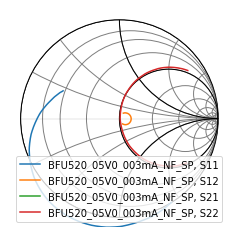

In [25]:
# the capacitance is kind of low but the inductance seems reasonable
# let's test it out

output_network = tem.inductor(l_ser)

amplifier = bjt ** output_network

amplifier.plot_s_smith()

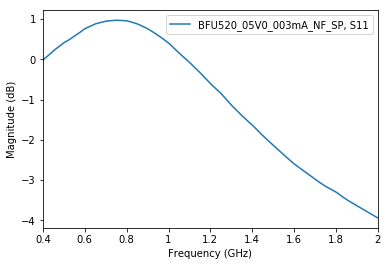

In [26]:
amplifier.s11.plot_s_db()

In [110]:
# the circuit is unstable so let's move the input impedance to try to stabilize it
# let's test a bunch of points and see we can find a stable one
nf = 10**(0.1/10) * fmin
    
N = (nf - fmin)*abs(1+gamma_opt)**2/(4*rn)
c_n = gamma_opt/(1+N)
r_n = 1/(1-N)*np.sqrt(N**2 + N*(1-abs(gamma_opt)**2))

bjt_s22 = bjt.s22.s[idx_900mhz, 0, 0]
bjt_s21 = bjt.s21.s[idx_900mhz, 0, 0]
bjt_s11 = bjt.s11.s[idx_900mhz, 0, 0]
bjt_s12 = bjt.s12.s[idx_900mhz, 0, 0]

for i in range(0, 100):
    gamma_s = c_n + r_n*np.exp(-2j*np.pi*i/100.)
    #z_s = net.s2z(np.array([[[gamma_s]]]))[0,0,0]
    is_gamma_s_stable = np.absolute(gamma_s - cs_900mhz) > rs_900mhz
    if not is_gamma_s_stable:
        continue
    
    gamma_l = np.conj(bjt_s22 + bjt_s21*gamma_s*bjt_s12/(1-bjt_s11*gamma_s))
    is_gamma_l_stable = np.absolute(gamma_l - cl_900mhz) > rl_900mhz
    if not is_gamma_l_stable:
        continue

    print(gamma_s, gamma_l)

(0.4962586711014507+0.23917093695061845j) (0.18228051694780179+0.36506979517749194j)
(0.49569287122840444+0.2211668930637062j) (0.19129931295477226+0.3623052098214076j)
(0.4939977045628752+0.20323390291275034j) (0.20028409631888006+0.3600278893091544j)
(0.49117986115324375+0.18544273981707285j) (0.20921875018082758+0.3582180066051195j)
(0.4872504617400978+0.167863617369403j) (0.21808932998905928+0.35685677017352446j)
(0.48222501386774913+0.1505659123349047j) (0.22688378378536478+0.35592649617299665j)
(0.47612335068304124+0.1336178908527794j) (0.23559169497464763+0.35541065392126203j)
(0.4689695526629794+0.11708643902100246j) (0.24420404670148016+0.35529388986894j)
(0.4607918525800893+0.10103679892745204j) (0.25271300656744233+0.35556203449564405j)
(0.45162252408056236+0.0855323111691943j) (0.26111173017347444+0.35620209580375295j)
(0.44149775431491856+0.07063416487608437j) (0.2693941818269482+0.357202242434259j)
(0.43045750112385545+0.05640115622522554j) (0.2775549706866734+0.358551778

In [202]:
#(0.4689695526629794+0.11708643902100246j) (0.24420404670148016+0.35529388986894j)
gamma_s = (0.13821946871574342-0.03855273649252047j)
gamma_l = (0.3980438614372531+0.43616650204314683j)
gamma_s = bjt.g_opt[idx_915mhz]

z_s = np.conj(net.s2z(np.array([[[gamma_s]]]))[0,0,0])
z_l = np.conj(net.s2z(np.array([[[gamma_l]]]))[0,0,0])

z_s, z_l

((66.2631010551724-38.52253932822274j), (58.93311731910662-78.9309614005669j))

In [203]:
x_s_1, x_s_2 = calc_matching_network_vals(z_s, 50)
x_l_1, x_l_2 = calc_matching_network_vals(z_l, 50)

x_s_1, x_s_2, x_l_1, x_l_2

(-297.56843939433804j,
 43.965021073542395j,
 -941.2755436141462j,
 75.71255337677657j)

In [204]:
c_s_shunt = np.real(1/(2j*np.pi*915e+6*x_s_1))
#c_s_ser = np.real(1/(2j*np.pi*915e+6*x_s_1))
l_s_ser = np.real(x_s_2/(2j*np.pi*915e+6))
c_l_shunt = np.real(1/(2j*np.pi*915e+6*x_l_1))
l_l_ser = np.real(x_l_2/(2j*np.pi*915e+6))

c_s_ser = -np.real(1/(2j*np.pi*915e+6*x_s_1))
l_s_shunt = -np.real(x_s_2/(2j*np.pi*915e+6))


#c_s_shunt, c_s_ser, c_l_shunt, l_l_ser
c_s_shunt, l_s_ser, c_l_shunt, l_l_ser

(5.845372206466672e-13,
 7.647268226222535e-09,
 1.8479161569190324e-13,
 1.3169428550844769e-08)

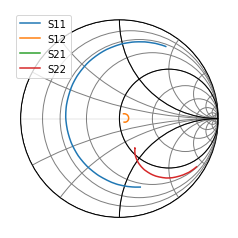

In [205]:
#input_network2 = tem.capacitor(c_s_ser) ** tem.shunt_capacitor(c_s_shunt)
input_network2 = tem.inductor(l_s_ser) ** tem.shunt_capacitor(c_s_shunt)
output_network2 = tem.shunt_capacitor(c_l_shunt) ** tem.inductor(l_l_ser)

#amplifier2 = input_network2 ** bjt ** output_network2
amplifier2 = input_network2 ** bjt #** output_network2

amplifier2.plot_s_smith()

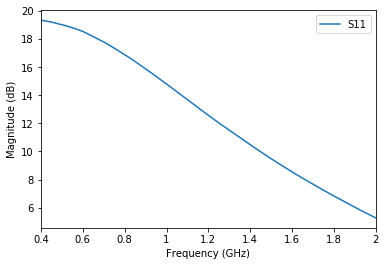

In [206]:
amplifier2.s21.plot_s_db()

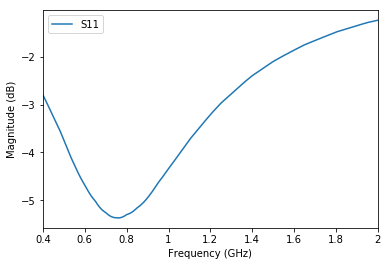

In [207]:
amplifier2.s11.plot_s_db()

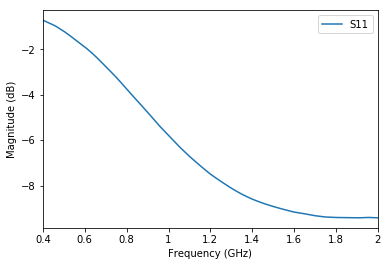

In [208]:
amplifier2.s22.plot_s_db()

In [209]:
10*np.log10(amplifier2.nf(50.)[idx_900mhz])

0.7063394274281913

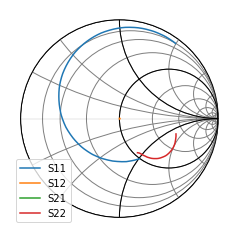

In [210]:
cascade = amplifier2 ** tem.resistor(22) ** amplifier2
cascade.plot_s_smith()

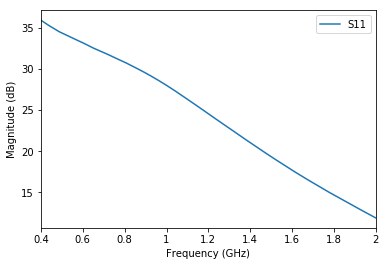

In [211]:
cascade.s21.plot_s_db()

In [212]:
10*np.log10(cascade.nf(50.)[idx_900mhz])

0.7351173919471382

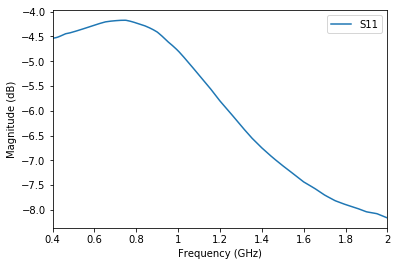

In [213]:
cascade.s22.plot_s_db()

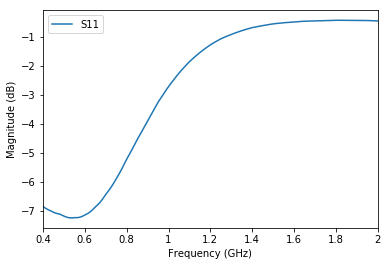

In [214]:
cascade.s11.plot_s_db()